In [8]:
import json
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Path to trace data directory
trace_dir = './results_store/_final/trace/avgnet/'

# Helper function to parse trace logs and extract timing information
def parse_trace_log(log_file):
    """Parse trace log file and extract operation timings"""
    timings = []
    operations = []
    
    # Track requests to match with their completion timings
    pending_requests = {}
    
    with open(log_file, 'r') as f:
        for line in f:
            # Extract timestamp and operation type
            if 'PUT request received' in line:
                timestamp_match = re.search(r'(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d+Z)', line)
                key_match = re.search(r'key: ([^\\s]+)', line)
                if timestamp_match and key_match:
                    timestamp = datetime.fromisoformat(timestamp_match.group(1).replace('Z', '+00:00'))
                    key = key_match.group(1)
                    operations.append({
                        'timestamp': timestamp,
                        'operation': 'PUT_REQUEST',
                        'type': 'request_start',
                        'key': key
                    })
                    pending_requests[key] = {'start_time': timestamp, 'type': 'PUT'}
                    
            elif 'GET request received' in line:
                timestamp_match = re.search(r'(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d+Z)', line)
                key_match = re.search(r'key: ([^\\s]+)', line)
                if timestamp_match and key_match:
                    timestamp = datetime.fromisoformat(timestamp_match.group(1).replace('Z', '+00:00'))
                    key = key_match.group(1)
                    operations.append({
                        'timestamp': timestamp,
                        'operation': 'GET_REQUEST',
                        'type': 'request_start',
                        'key': key
                    })
                    pending_requests[key] = {'start_time': timestamp, 'type': 'GET'}
                    
            elif 'time.busy=' in line and 'time.idle=' in line:
                # Extract timing information
                timestamp_match = re.search(r'(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d+Z)', line)
                busy_match = re.search(r'time\.busy=([0-9.]+[µμmns]*)', line)
                idle_match = re.search(r'time\.idle=([0-9.]+[µμmns]*)', line)
                
                if timestamp_match and busy_match and idle_match:
                    timestamp = datetime.fromisoformat(timestamp_match.group(1).replace('Z', '+00:00'))
                    busy_time = parse_time_value(busy_match.group(1))
                    idle_time = parse_time_value(idle_match.group(1))
                    
                    # Determine operation type from context and file path
                    operation_type = 'UNKNOWN'
                    operation_layer = 'UNKNOWN'
                    
                    # Determine the operation layer
                    if '_memory_store.rs' in line:
                        operation_layer = 'MEMORY_STORE'
                    elif '_persistent_store.rs' in line:
                        operation_layer = 'PERSISTENT_STORE'
                    elif 'http_put:' in line:
                        operation_layer = 'HTTP_PUT'
                    elif 'http_get:' in line:
                        operation_layer = 'HTTP_GET'
                    elif 'send_omnipaxos_request:' in line:
                        operation_layer = 'OMNIPAXOS_REQUEST'
                    
                    # Determine operation type
                    if 'set:' in line:
                        operation_type = 'SET'
                    elif 'get:' in line:
                        operation_type = 'GET'
                    elif 'http_put:' in line:
                        operation_type = 'HTTP_PUT'
                    elif 'http_get:' in line:
                        operation_type = 'HTTP_GET'
                    elif 'send_omnipaxos_request:' in line:
                        operation_type = 'OMNIPAXOS_REQUEST'
                    
                    # Combine operation type and layer for better analysis
                    combined_operation = f"{operation_type}_{operation_layer}" if operation_layer != 'UNKNOWN' else operation_type
                    
                    timings.append({
                        'timestamp': timestamp,
                        'operation': combined_operation,
                        'operation_type': operation_type,
                        'operation_layer': operation_layer,
                        'busy_time_ms': busy_time,
                        'idle_time_ms': idle_time,
                        'total_time_ms': busy_time + idle_time,
                        'log_line': line.strip()[:200]  # Store truncated line for debugging
                    })
    
    return pd.DataFrame(timings), pd.DataFrame(operations)

def parse_time_value(time_str):
    """Convert time string to milliseconds"""
    time_str = time_str.strip()
    
    if 'µs' in time_str or 'μs' in time_str:
        return float(time_str.replace('µs', '').replace('μs', '')) / 1000
    elif 'ms' in time_str:
        return float(time_str.replace('ms', ''))
    elif time_str.endswith('m') and not time_str.endswith('ms'):
        # Handle minutes
        return float(time_str.replace('m', '')) * 60 * 1000
    elif time_str.endswith('s') and not time_str.endswith('µs') and not time_str.endswith('μs') and not time_str.endswith('ms'):
        # Handle seconds (but not microseconds or milliseconds)
        return float(time_str.replace('s', '')) * 1000
    else:
        # Try to parse as number - assume microseconds if no unit
        try:
            return float(time_str) / 1000
        except ValueError:
            # If parsing fails, return 0 and print warning
            print(f"Warning: Could not parse time value: {time_str}")
            return 0.0

def get_system_type_from_logs(log_file):
    """Determine if this is an erasure or replication system from log content"""
    with open(log_file, 'r') as f:
        first_100_lines = [f.readline() for _ in range(100)]
    
    # Check for erasure coding indicators
    erasure_indicators = ['src/ec/']
    replication_indicators = ['src/standard/']
    
    content = ' '.join(first_100_lines)
    
    erasure_count = sum(1 for indicator in erasure_indicators if indicator in content)
    replication_count = sum(1 for indicator in replication_indicators if indicator in content)
    
    if erasure_count > replication_count:
        return 'Erasure'
    else:
        return 'Replication'

print("Helper functions loaded successfully!")

Helper functions loaded successfully!


In [9]:
# Collect all trace files and metadata
def collect_trace_data():
    """Collect and organize all trace data files"""
    trace_files = glob.glob(f'{trace_dir}trace_*.log')
    metadata_files = glob.glob(f'{trace_dir}trace_*_metadata.json')
    
    trace_data = []
    
    for metadata_file in metadata_files:
        with open(metadata_file, 'r') as f:
            metadata = json.load(f)
        
        # Find corresponding log file
        log_file = metadata_file.replace('_metadata.json', '.log')
        if log_file in trace_files:
            # Parse the filename to extract parameters
            filename = log_file.split('/')[-1]
            match = re.search(r'trace_(\w+)_(\w+)_(\d+)b_(\d+)vu_([^_]+)_(\d+)_(\d+)\.log', filename)
            
            if match:
                test_type = match.group(1)
                system_type = 'Erasure' if match.group(2) == 'erasure' else 'Replication'
                payload_size = int(match.group(3))
                virtual_users = int(match.group(4))
                bandwidth = match.group(5)
                
                # Verify system type from log content
                detected_system_type = get_system_type_from_logs(log_file)
                if detected_system_type != system_type:
                    print(f"WARNING: Filename suggests {system_type} but log content suggests {detected_system_type} for {filename}")
                    system_type = detected_system_type
                
                trace_data.append({
                    'test_type': test_type,
                    'system_type': system_type,
                    'payload_size': payload_size,
                    'virtual_users': virtual_users,
                    'bandwidth': bandwidth,
                    'log_file': log_file,
                    'metadata': metadata
                })
    
    # Sort by test_type (read first, then write), system_type (Erasure first, then Replication), payload_size, bandwidth, then virtual_users
    def test_type_sort_key(x):
        return 0 if x['test_type'] == 'read' else 1
    def system_type_sort_key(x):
        return 0 if x['system_type'] == 'Erasure' else 1
    trace_data.sort(key=lambda x: (
        test_type_sort_key(x),
        system_type_sort_key(x),
        x['payload_size'],
        x['bandwidth'],
        x['virtual_users']
    ))
    return trace_data

# Load all trace data
trace_data = collect_trace_data()
print(f"Found {len(trace_data)} trace files:")
for td in trace_data:
    print(f"  {td['test_type']}/{td['system_type']}: {td['payload_size']}B, {td['virtual_users']}vu, {td['bandwidth']}")

# Processing with layer-aware analysis
processed_data = []

for td in trace_data:
    print(f"Processing {td['test_type']}/{td['system_type']}...")
    timings_df, operations_df = parse_trace_log(td['log_file'])
    
    if not timings_df.empty:
        # Aggregate metrics across all operations
        all_metrics = {
            'test_type': td['test_type'],
            'system_type': td['system_type'],
            'payload_size': td['payload_size'],
            'virtual_users': td['virtual_users'],
            'bandwidth': td['bandwidth'],
            'total_operations': len(timings_df),
            'avg_busy_time_ms': timings_df['busy_time_ms'].mean(),
            'avg_idle_time_ms': timings_df['idle_time_ms'].mean(),
            'avg_total_time_ms': timings_df['total_time_ms'].mean(),
            'p50_busy_time_ms': timings_df['busy_time_ms'].quantile(0.5),
            'p90_busy_time_ms': timings_df['busy_time_ms'].quantile(0.9),
            'p95_busy_time_ms': timings_df['busy_time_ms'].quantile(0.95),
            'p50_total_time_ms': timings_df['total_time_ms'].quantile(0.5),
            'p90_total_time_ms': timings_df['total_time_ms'].quantile(0.9),
            'p95_total_time_ms': timings_df['total_time_ms'].quantile(0.95),
            'operations_per_second': len(timings_df) / ((timings_df['timestamp'].max() - timings_df['timestamp'].min()).total_seconds()) if len(timings_df) > 1 else 0
        }
        
        # Calculate layer-specific metrics for better comparison
        layer_metrics = {}
        for layer in timings_df['operation_layer'].unique():
            layer_data = timings_df[timings_df['operation_layer'] == layer]
            if not layer_data.empty:
                layer_metrics[f'{layer.lower()}_count'] = len(layer_data)
                layer_metrics[f'{layer.lower()}_avg_busy_ms'] = layer_data['busy_time_ms'].mean()
                layer_metrics[f'{layer.lower()}_avg_idle_ms'] = layer_data['idle_time_ms'].mean()
                layer_metrics[f'{layer.lower()}_p90_busy_ms'] = layer_data['busy_time_ms'].quantile(0.9)
        
        # Combine all metrics
        combined_metrics = {**all_metrics, **layer_metrics}
        
        # Store raw timing data for detailed analysis
        timings_df['test_type'] = td['test_type']
        timings_df['system_type'] = td['system_type']
        timings_df['payload_size'] = td['payload_size']
        timings_df['virtual_users'] = td['virtual_users']
        timings_df['bandwidth'] = td['bandwidth']
        
        processed_data.append({
            'metrics': combined_metrics,
            'timings': timings_df,
            'operations': operations_df
        })
        
        # Print summary for this trace
        print(f"  - Total timing entries: {len(timings_df)}")
        print(f"  - Operation layers found: {list(timings_df['operation_layer'].unique())}")
        print(f"  - Avg busy time: {timings_df['busy_time_ms'].mean():.2f}ms")
        print(f"  - Avg idle time: {timings_df['idle_time_ms'].mean():.2f}ms")

# Create summary dataframe
if processed_data:
    summary_df = pd.DataFrame([pd['metrics'] for pd in processed_data])
    # Use mapping dicts for custom sort order
    test_type_order = {'read': 0, 'write': 1}
    system_type_order = {'Erasure': 0, 'Replication': 1}
    summary_df['test_type_order'] = summary_df['test_type'].map(test_type_order)
    summary_df['system_type_order'] = summary_df['system_type'].map(system_type_order)
    summary_df = summary_df.sort_values(
        by=['test_type_order', 'system_type_order', 'payload_size', 'bandwidth', 'virtual_users']
    ).reset_index(drop=True)
    summary_df = summary_df.drop(columns=['test_type_order', 'system_type_order'])
    print(f"\nProcessed {len(summary_df)} trace datasets")
    
    # Display layer distribution summary
    print("\nLayer Distribution Summary:")
    for idx, row in summary_df.iterrows():
        config = f"{row['test_type']}/{row['system_type']} {row['payload_size']}B {row['bandwidth']}"
        layers = []
        for col in row.index:
            if col.endswith('_count') and row[col] > 0:
                layer_name = col.replace('_count', '').upper()
                layers.append(f"{layer_name}({int(row[col])})")
        print(f"  {config}: {', '.join(layers)}")
    
    summary_df.head()
else:
    summary_df = pd.DataFrame()
    print("\nNo trace datasets processed.")
    summary_df.head()

Found 100 trace files:
  read/Erasure: 200000B, 1vu, 10mbit
  read/Erasure: 200000B, 1vu, 25mbit
  read/Erasure: 200000B, 1vu, 40mbit
  read/Erasure: 200000B, 1vu, 55mbit
  read/Erasure: 200000B, 1vu, 70mbit
  read/Erasure: 400000B, 1vu, 10mbit
  read/Erasure: 400000B, 1vu, 25mbit
  read/Erasure: 400000B, 1vu, 40mbit
  read/Erasure: 400000B, 1vu, 55mbit
  read/Erasure: 400000B, 1vu, 70mbit
  read/Erasure: 600000B, 1vu, 10mbit
  read/Erasure: 600000B, 1vu, 25mbit
  read/Erasure: 600000B, 1vu, 40mbit
  read/Erasure: 600000B, 1vu, 55mbit
  read/Erasure: 600000B, 1vu, 70mbit
  read/Erasure: 800000B, 1vu, 10mbit
  read/Erasure: 800000B, 1vu, 25mbit
  read/Erasure: 800000B, 1vu, 40mbit
  read/Erasure: 800000B, 1vu, 55mbit
  read/Erasure: 800000B, 1vu, 70mbit
  read/Erasure: 1000000B, 1vu, 10mbit
  read/Erasure: 1000000B, 1vu, 25mbit
  read/Erasure: 1000000B, 1vu, 40mbit
  read/Erasure: 1000000B, 1vu, 55mbit
  read/Erasure: 1000000B, 1vu, 70mbit
  read/Replication: 200000B, 1vu, 10mbit
  read

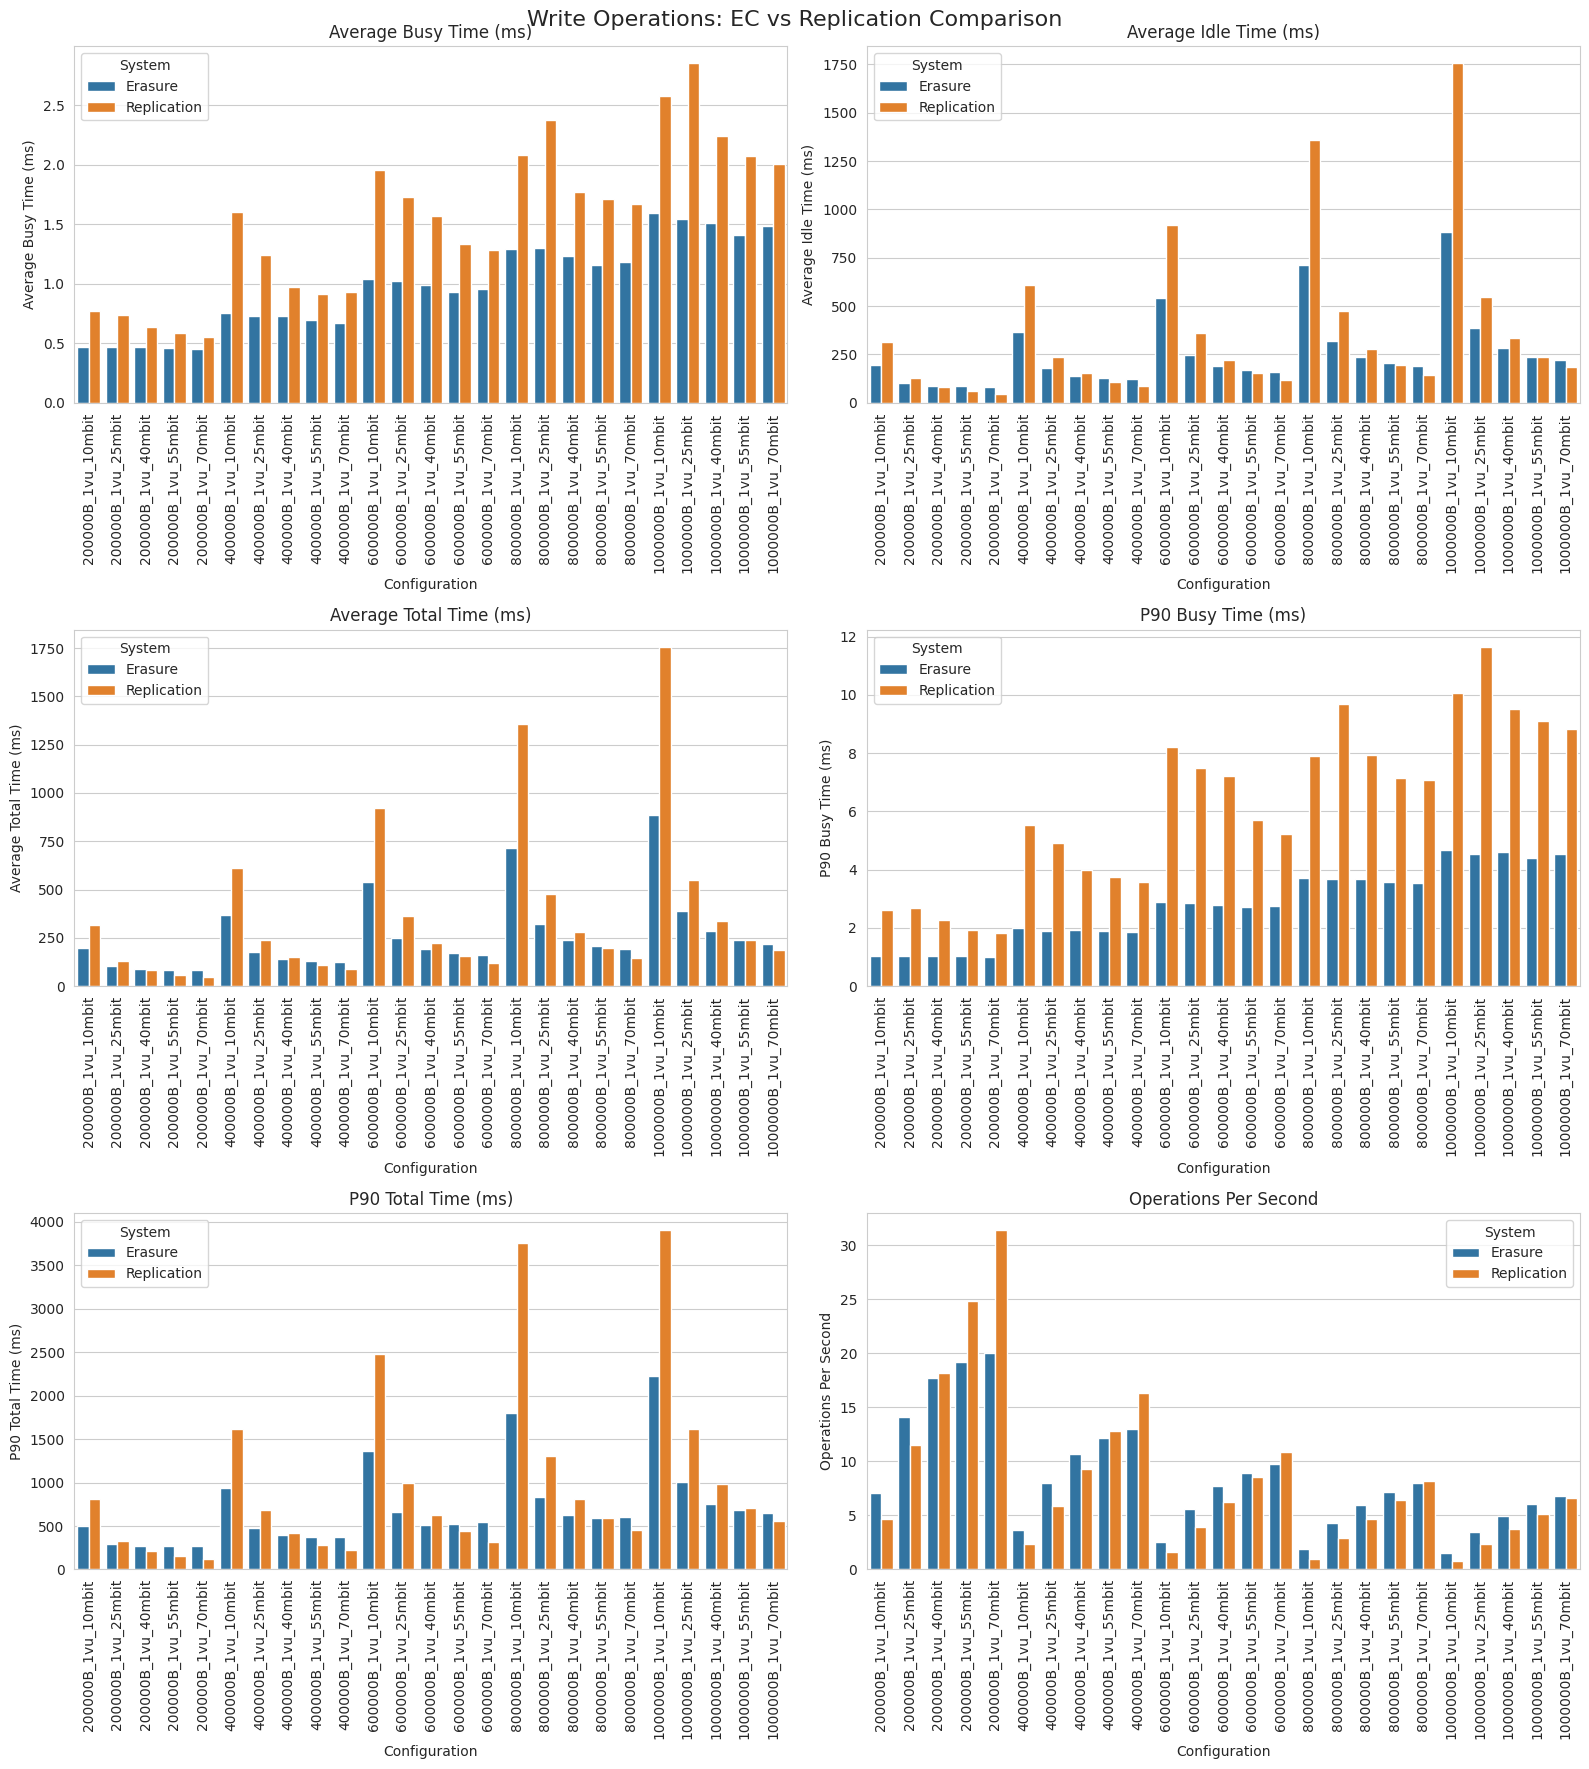

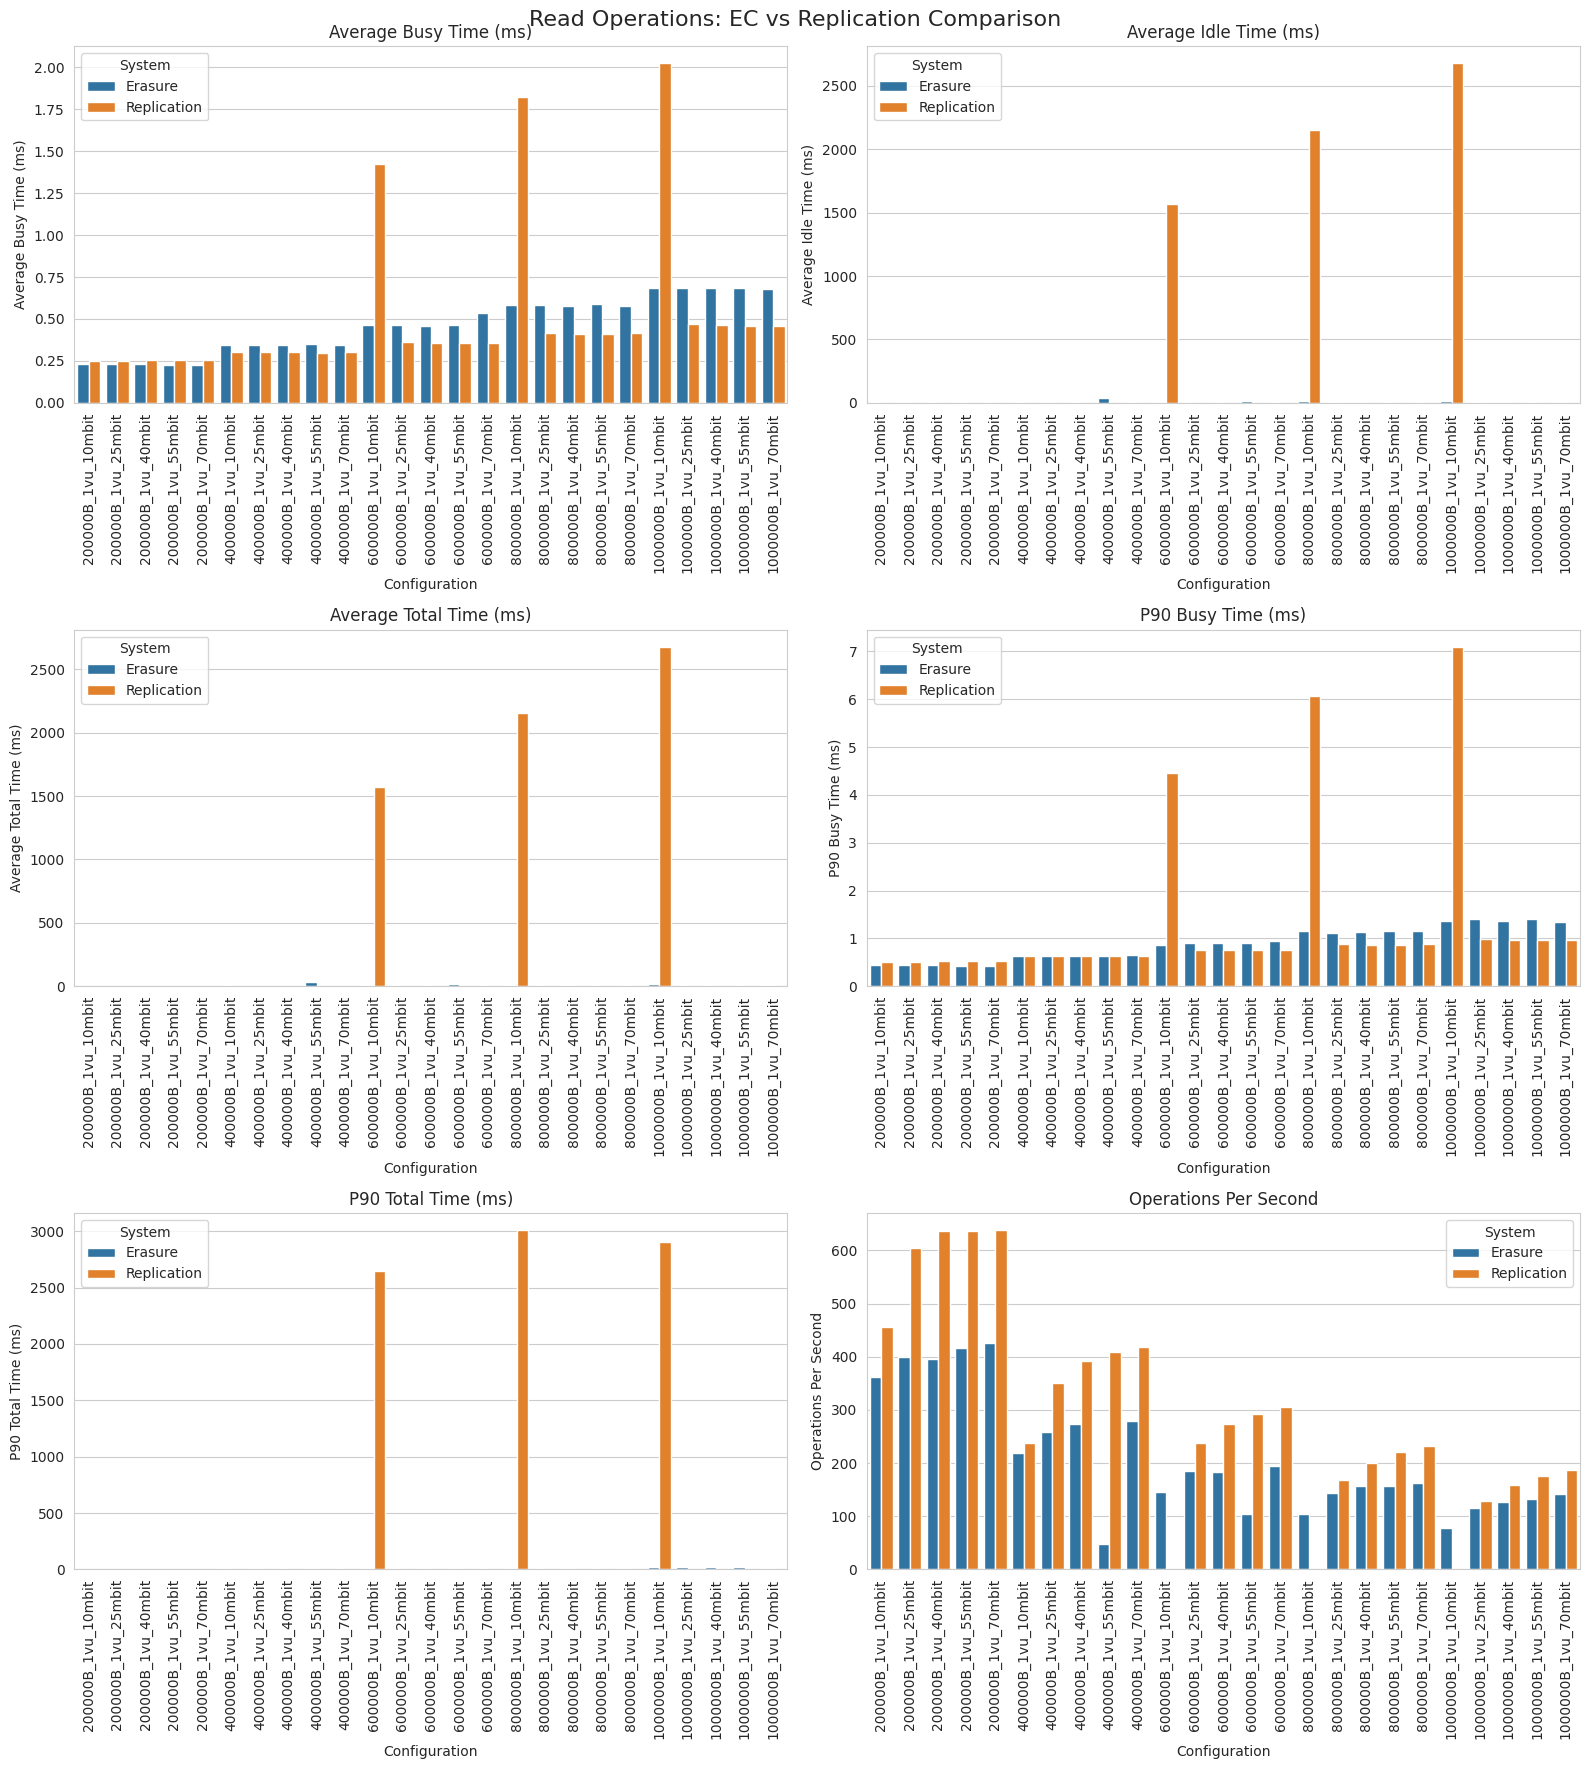

In [10]:
# Comparative Analysis: EC vs Replication
if not summary_df.empty:
    # Group by test type for separate analysis
    write_data = summary_df[summary_df['test_type'] == 'write']
    read_data = summary_df[summary_df['test_type'] == 'read']
    
    # Define metrics to compare
    timing_metrics = [
        ('avg_busy_time_ms', 'Average Busy Time (ms)'),
        ('avg_idle_time_ms', 'Average Idle Time (ms)'),
        ('avg_total_time_ms', 'Average Total Time (ms)'),
        ('p90_busy_time_ms', 'P90 Busy Time (ms)'),
        ('p90_total_time_ms', 'P90 Total Time (ms)'),
        ('operations_per_second', 'Operations Per Second')
    ]
    
    def plot_comparison(data, test_type):
        if data.empty:
            print(f"No data available for {test_type} operations")
            return
            
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))
        fig.suptitle(f'{test_type.title()} Operations: EC vs Replication Comparison', fontsize=16)
        
        for idx, (metric, title) in enumerate(timing_metrics):
            ax = axes[idx // 2, idx % 2]
            
            # Create comparison data
            comparison_data = []
            for _, row in data.iterrows():
                comparison_data.append({
                    'System': row['system_type'],
                    'Value': row[metric],
                    'Config': f"{row['payload_size']}B_{row['virtual_users']}vu_{row['bandwidth']}"
                })
            
            comp_df = pd.DataFrame(comparison_data)
            
            if not comp_df.empty:
                sns.barplot(data=comp_df, x='Config', y='Value', hue='System', ax=ax)
                ax.set_title(title)
                ax.set_xlabel('Configuration')
                ax.set_ylabel(title)
                ax.tick_params(axis='x', rotation=90)
        
        plt.tight_layout()
        plt.show()
    
    # Plot comparisons for write and read operations
    plot_comparison(write_data, 'write')
    plot_comparison(read_data, 'read')
else:
    print("No summary data available for comparison")

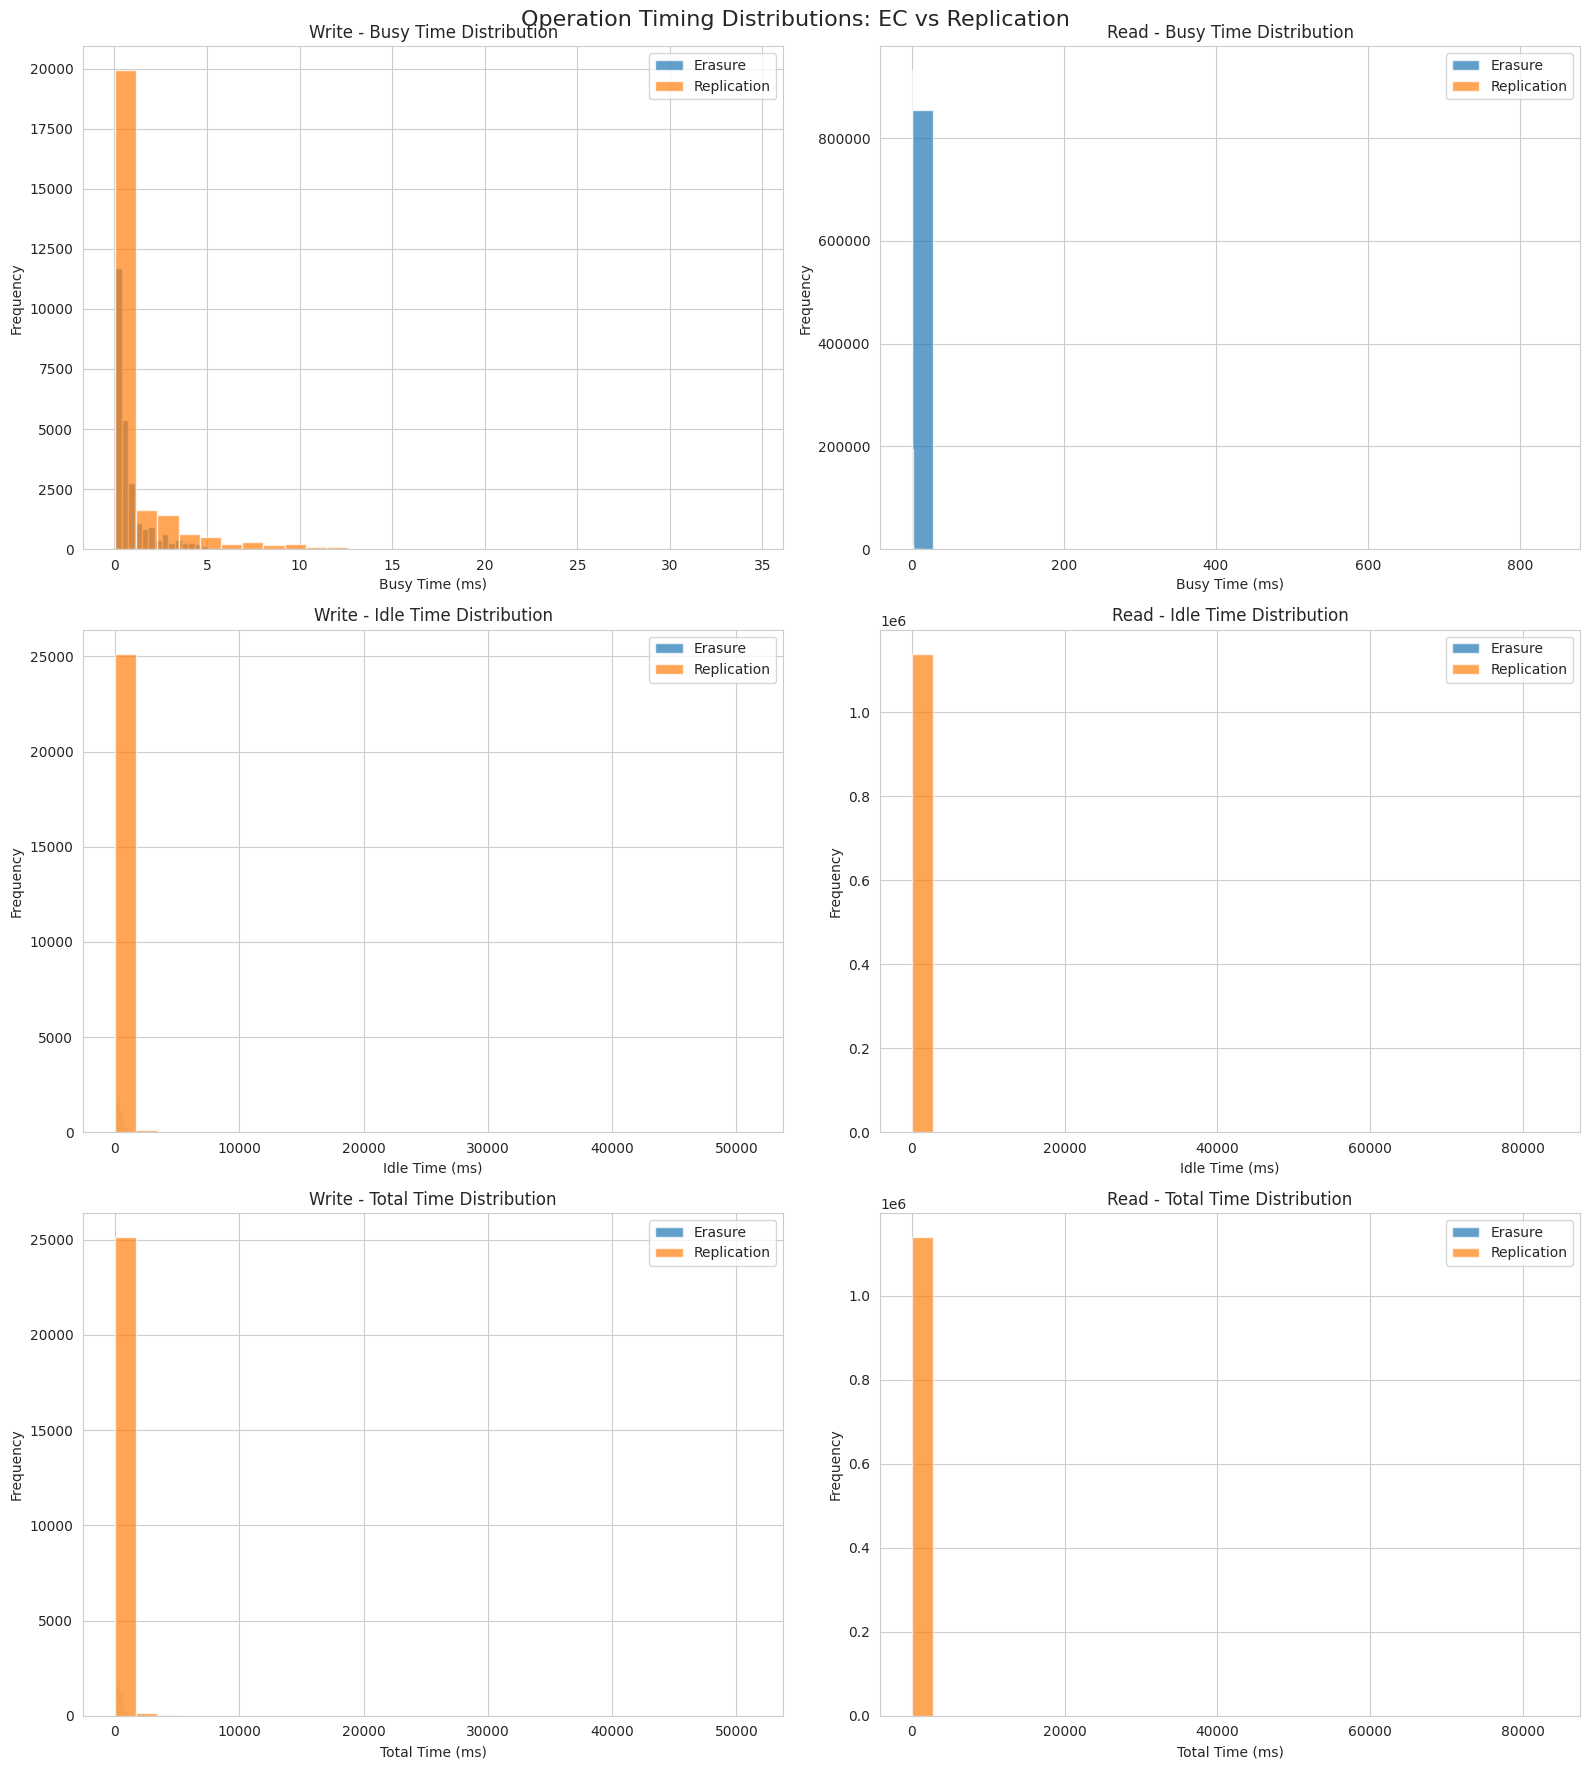

In [11]:
# Operation Timing Distributions
def plot_timing_distributions():
    """Plot timing distributions for different operation types"""
    if not processed_data:
        print("No processed data available")
        return
    
    # Combine all timing data
    all_timings = []
    for pd_item in processed_data:
        timings = pd_item['timings'].copy()
        all_timings.append(timings)
    
    if not all_timings:
        print("No timing data available")
        return
    
    combined_timings = pd.concat(all_timings, ignore_index=True)
    
    # Plot distributions by system type and test type
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle('Operation Timing Distributions: EC vs Replication', fontsize=16)
    
    # Busy time distribution by test type
    for idx, test_type in enumerate(['write', 'read']):
        test_data = combined_timings[combined_timings['test_type'] == test_type]
        
        if not test_data.empty:
            ax = axes[0, idx]
            for system in ['Erasure', 'Replication']:
                system_data = test_data[test_data['system_type'] == system]
                if not system_data.empty:
                    ax.hist(system_data['busy_time_ms'], alpha=0.7, label=system, bins=30)
            
            ax.set_title(f'{test_type.title()} - Busy Time Distribution')
            ax.set_xlabel('Busy Time (ms)')
            ax.set_ylabel('Frequency')
            ax.legend()
    
    # Idle time distribution by test type
    for idx, test_type in enumerate(['write', 'read']):
        test_data = combined_timings[combined_timings['test_type'] == test_type]
        
        if not test_data.empty:
            ax = axes[1, idx]
            for system in ['Erasure', 'Replication']:
                system_data = test_data[test_data['system_type'] == system]
                if not system_data.empty:
                    ax.hist(system_data['idle_time_ms'], alpha=0.7, label=system, bins=30)
            
            ax.set_title(f'{test_type.title()} - Idle Time Distribution')
            ax.set_xlabel('Idle Time (ms)')
            ax.set_ylabel('Frequency')
            ax.legend()
    
    # Total time distribution by test type
    for idx, test_type in enumerate(['write', 'read']):
        test_data = combined_timings[combined_timings['test_type'] == test_type]
        
        if not test_data.empty:
            ax = axes[2, idx]
            for system in ['Erasure', 'Replication']:
                system_data = test_data[test_data['system_type'] == system]
                if not system_data.empty:
                    ax.hist(system_data['total_time_ms'], alpha=0.7, label=system, bins=30)
            
            ax.set_title(f'{test_type.title()} - Total Time Distribution')
            ax.set_xlabel('Total Time (ms)')
            ax.set_ylabel('Frequency')
            ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_timing_distributions()

/tmp/ipykernel_3602842/1796200233.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/ostree/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


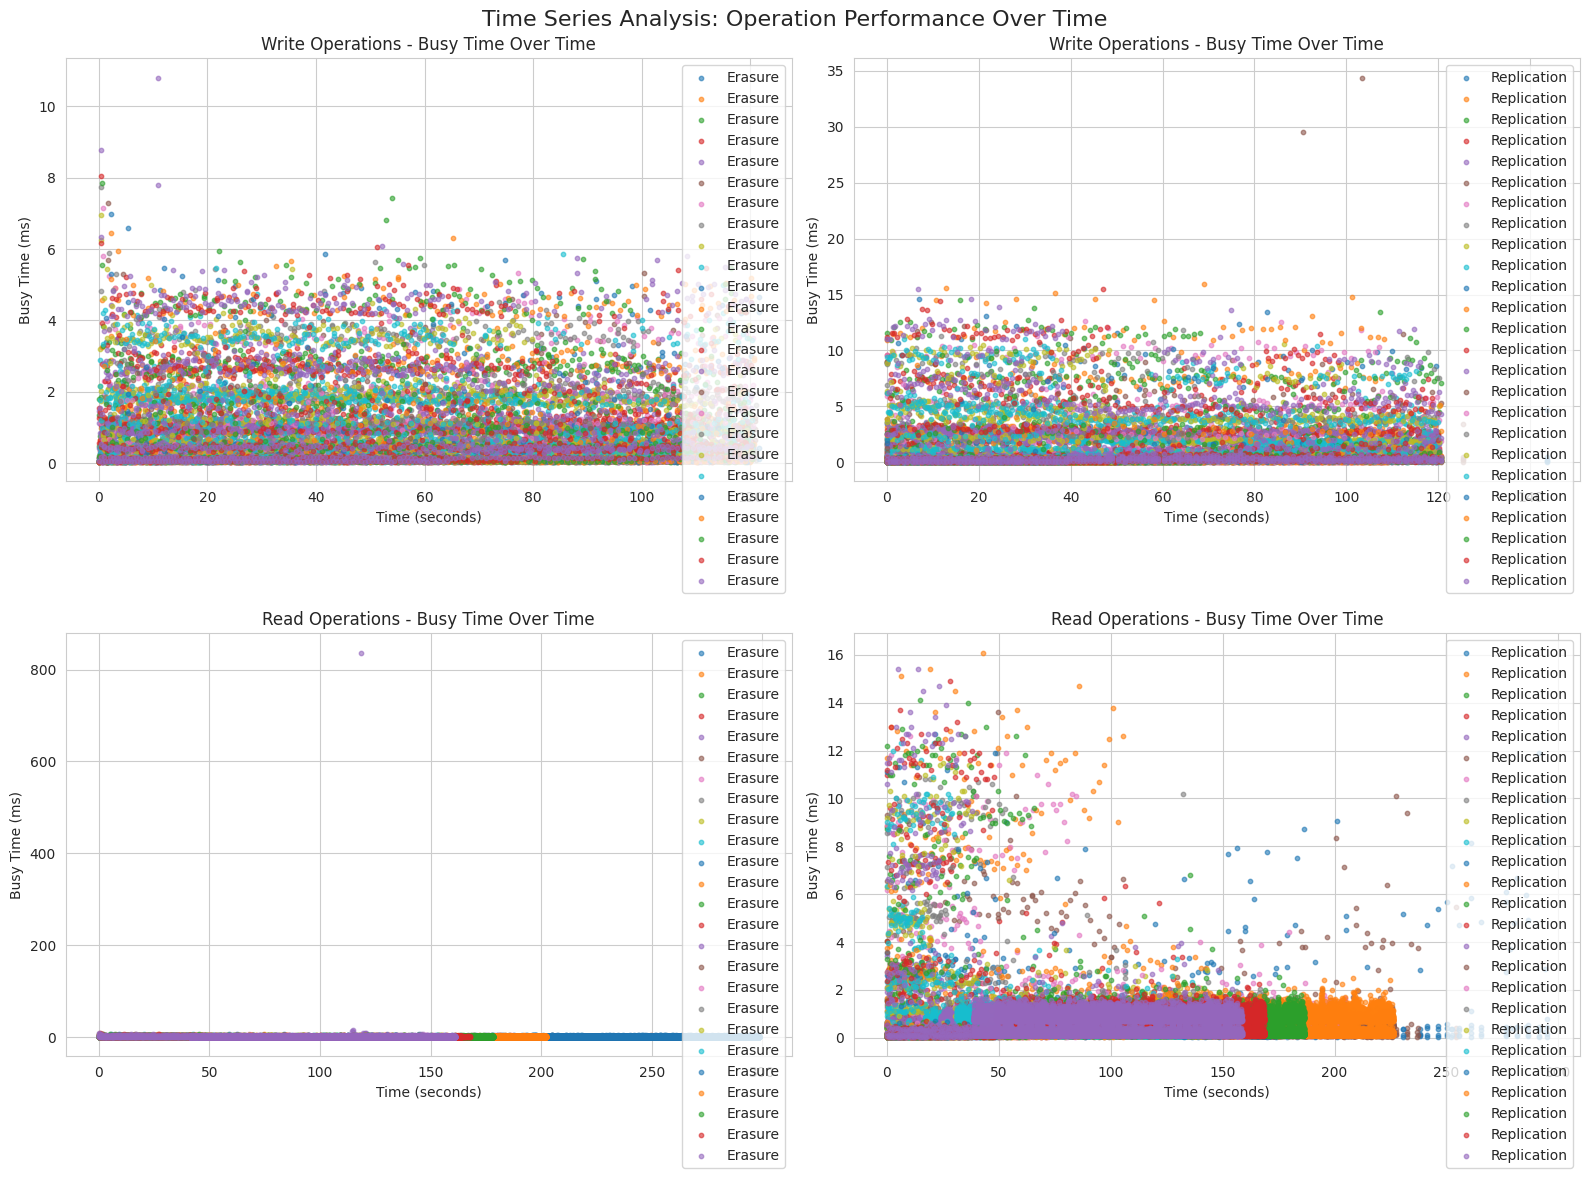

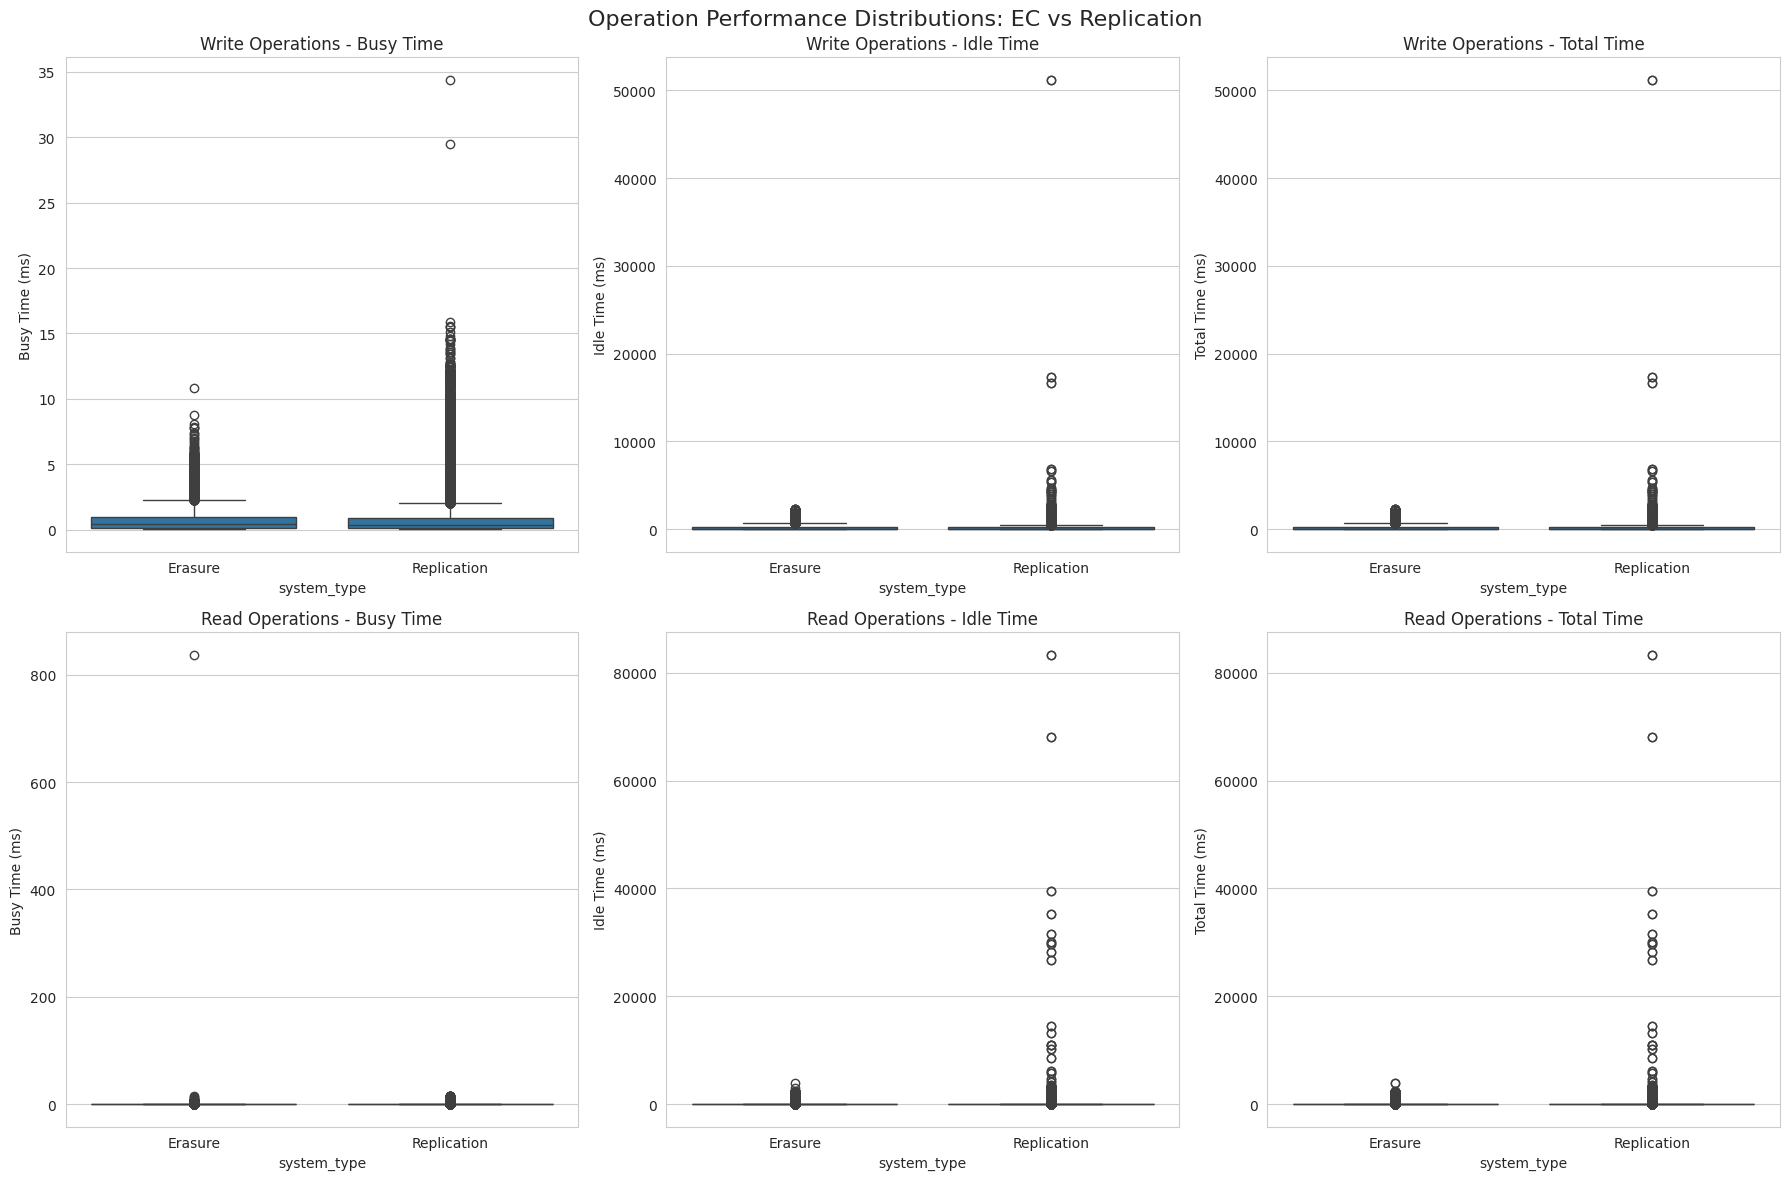

In [12]:
# Time Series Analysis and Boxplot Comparisons
def plot_time_series_and_boxplots():
    """Plot time series of operations and boxplot comparisons"""
    if not processed_data:
        print("No processed data available")
        return
    
    # Time series plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Time Series Analysis: Operation Performance Over Time', fontsize=16)
    
    for pd_item in processed_data:
        timings = pd_item['timings']
        if timings.empty:
            continue
            
        test_type = timings['test_type'].iloc[0]
        system_type = timings['system_type'].iloc[0]
        
        # Calculate relative time in seconds from start
        start_time = timings['timestamp'].min()
        timings['relative_time'] = (timings['timestamp'] - start_time).dt.total_seconds()
        
        # Plot busy time over time
        if test_type == 'write':
            ax = axes[0, 0] if system_type == 'Erasure' else axes[0, 1]
            ax.scatter(timings['relative_time'], timings['busy_time_ms'], 
                      alpha=0.6, s=10, label=f'{system_type}')
            ax.set_title(f'Write Operations - Busy Time Over Time')
            ax.set_xlabel('Time (seconds)')
            ax.set_ylabel('Busy Time (ms)')
            ax.legend()
        
        elif test_type == 'read':
            ax = axes[1, 0] if system_type == 'Erasure' else axes[1, 1]
            ax.scatter(timings['relative_time'], timings['busy_time_ms'], 
                      alpha=0.6, s=10, label=f'{system_type}')
            ax.set_title(f'Read Operations - Busy Time Over Time')
            ax.set_xlabel('Time (seconds)')
            ax.set_ylabel('Busy Time (ms)')
            ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Boxplot comparisons
    if processed_data:
        all_timings = pd.concat([pd_item['timings'] for pd_item in processed_data], ignore_index=True)
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Operation Performance Distributions: EC vs Replication', fontsize=16)
        
        # Write operations - Busy time
        write_data = all_timings[all_timings['test_type'] == 'write']
        if not write_data.empty:
            sns.boxplot(data=write_data, x='system_type', y='busy_time_ms', ax=axes[0, 0])
            axes[0, 0].set_title('Write Operations - Busy Time')
            axes[0, 0].set_ylabel('Busy Time (ms)')
        
        # Write operations - Idle time
        if not write_data.empty:
            sns.boxplot(data=write_data, x='system_type', y='idle_time_ms', ax=axes[0, 1])
            axes[0, 1].set_title('Write Operations - Idle Time')
            axes[0, 1].set_ylabel('Idle Time (ms)')
        
        # Write operations - Total time
        if not write_data.empty:
            sns.boxplot(data=write_data, x='system_type', y='total_time_ms', ax=axes[0, 2])
            axes[0, 2].set_title('Write Operations - Total Time')
            axes[0, 2].set_ylabel('Total Time (ms)')
        
        # Read operations - Busy time
        read_data = all_timings[all_timings['test_type'] == 'read']
        if not read_data.empty:
            sns.boxplot(data=read_data, x='system_type', y='busy_time_ms', ax=axes[1, 0])
            axes[1, 0].set_title('Read Operations - Busy Time')
            axes[1, 0].set_ylabel('Busy Time (ms)')
        
        # Read operations - Idle time
        if not read_data.empty:
            sns.boxplot(data=read_data, x='system_type', y='idle_time_ms', ax=axes[1, 1])
            axes[1, 1].set_title('Read Operations - Idle Time')
            axes[1, 1].set_ylabel('Idle Time (ms)')
        
        # Read operations - Total time
        if not read_data.empty:
            sns.boxplot(data=read_data, x='system_type', y='total_time_ms', ax=axes[1, 2])
            axes[1, 2].set_title('Read Operations - Total Time')
            axes[1, 2].set_ylabel('Total Time (ms)')
        
        plt.tight_layout()
        plt.show()

plot_time_series_and_boxplots()

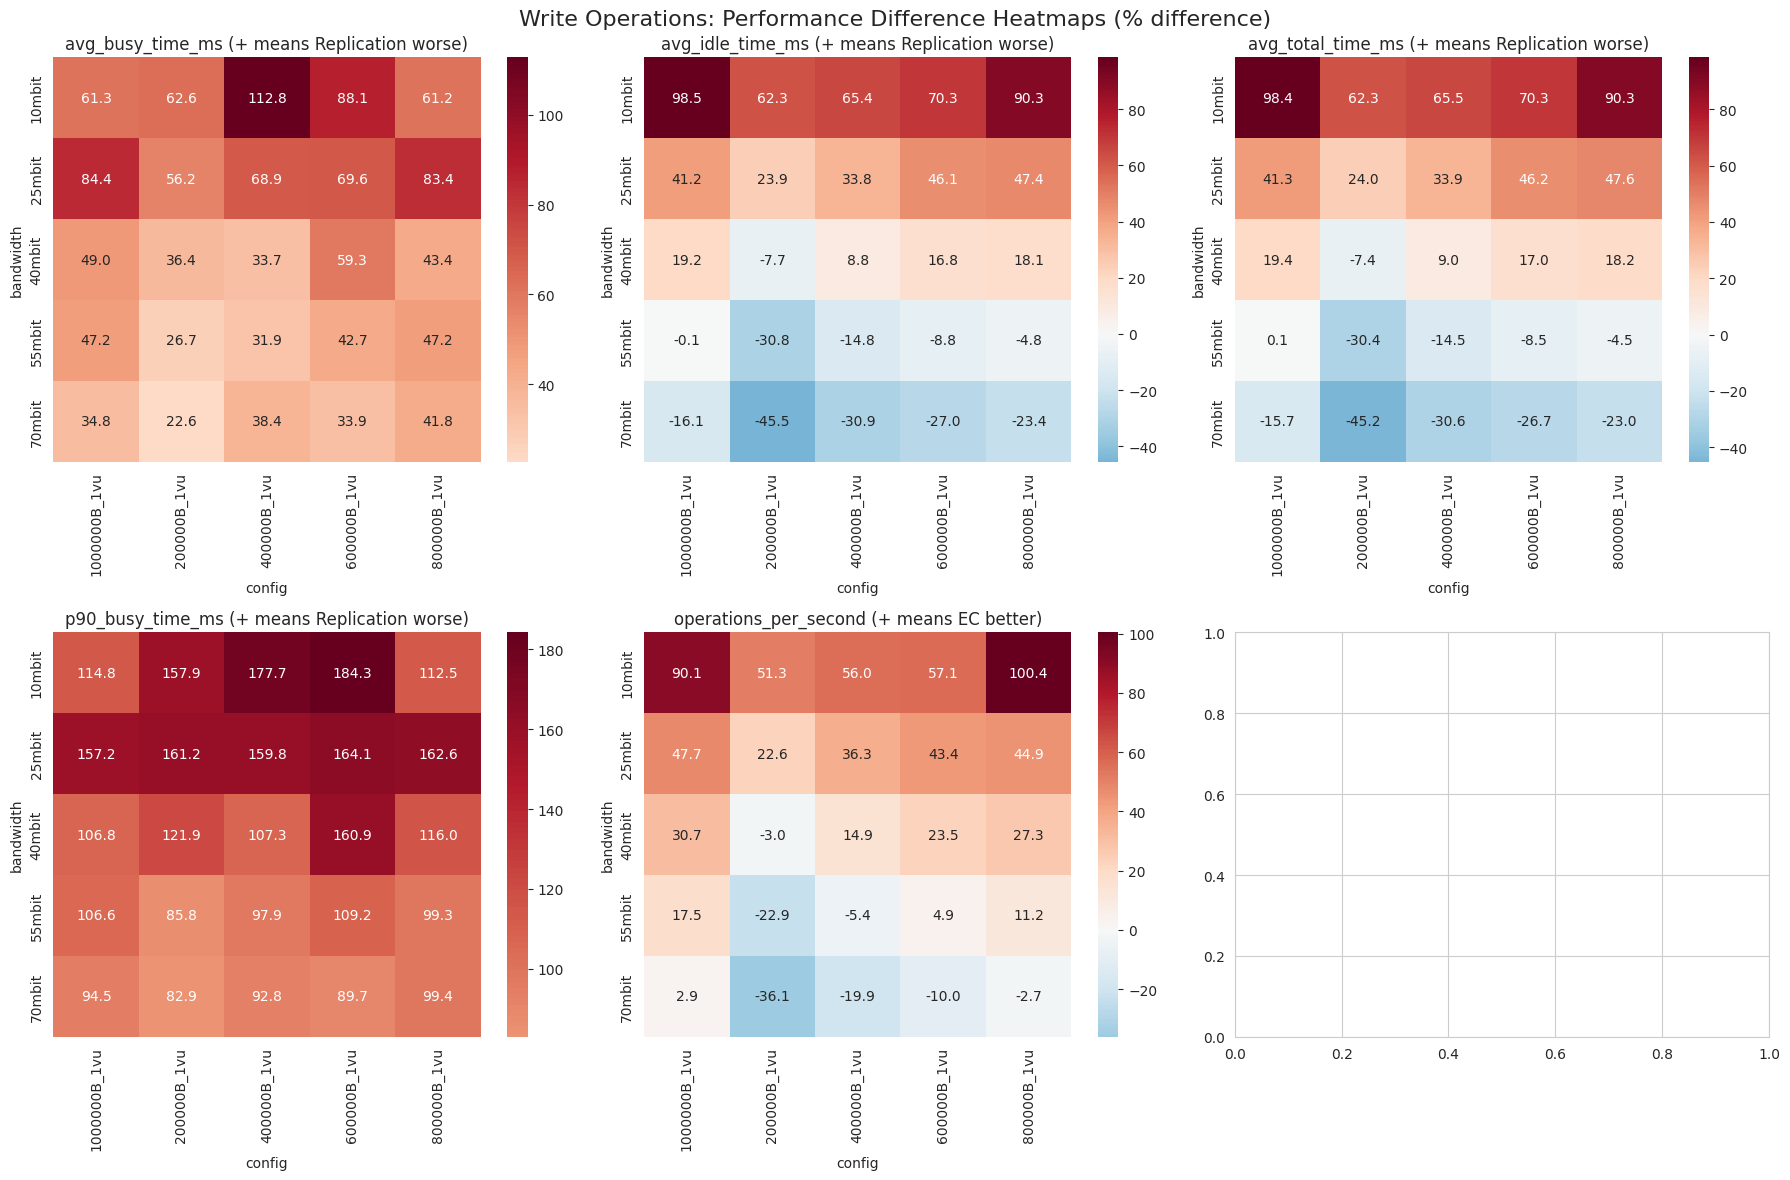

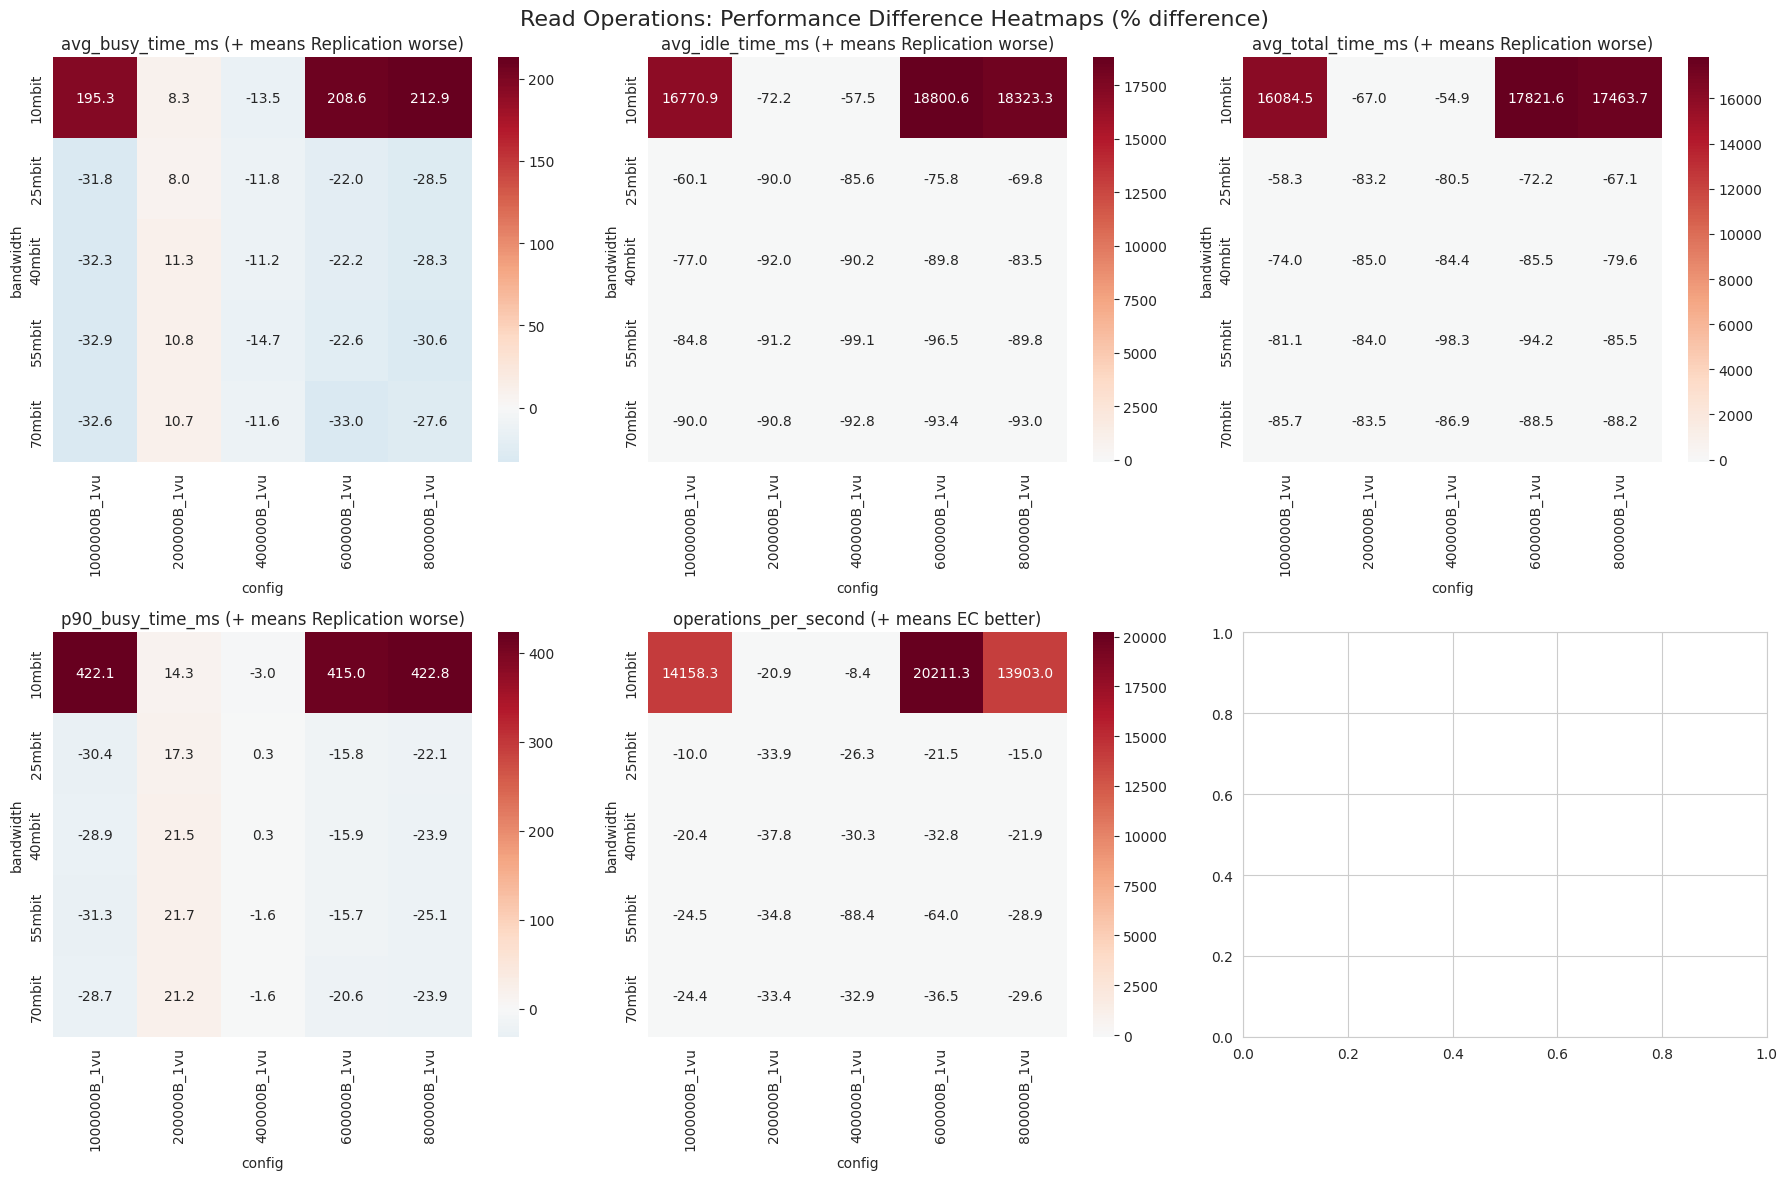

Summary Statistics: EC vs Replication Performance

WRITE OPERATIONS:
----------------------------------------

Configuration: 200000B_1vu_10mbit
System: Erasure
  Total Operations: 850
  Avg Busy Time: 0.47 ms
  P90 Busy Time: 1.02 ms
  Avg Total Time: 194.98 ms
  Operations/sec: 7.06

Configuration: 200000B_1vu_25mbit
System: Erasure
  Total Operations: 1695
  Avg Busy Time: 0.47 ms
  P90 Busy Time: 1.03 ms
  Avg Total Time: 104.58 ms
  Operations/sec: 14.10

Configuration: 200000B_1vu_40mbit
System: Erasure
  Total Operations: 2125
  Avg Busy Time: 0.47 ms
  P90 Busy Time: 1.03 ms
  Avg Total Time: 88.55 ms
  Operations/sec: 17.67

Configuration: 200000B_1vu_55mbit
System: Erasure
  Total Operations: 2305
  Avg Busy Time: 0.46 ms
  P90 Busy Time: 1.04 ms
  Avg Total Time: 85.54 ms
  Operations/sec: 19.15

Configuration: 200000B_1vu_70mbit
System: Erasure
  Total Operations: 2415
  Avg Busy Time: 0.45 ms
  P90 Busy Time: 1.01 ms
  Avg Total Time: 84.19 ms
  Operations/sec: 20.06

Conf

In [13]:
# Performance Heatmaps and Summary Statistics
def plot_performance_heatmaps():
    """Create heatmaps showing performance differences between EC and Replication"""
    if summary_df.empty:
        print("No summary data available")
        return
    
    # Calculate performance differences
    metrics_to_compare = ['avg_busy_time_ms', 'avg_idle_time_ms', 'avg_total_time_ms', 'p90_busy_time_ms', 'operations_per_second']
    
    for test_type in ['write', 'read']:
        test_data = summary_df[summary_df['test_type'] == test_type]
        
        if test_data.empty:
            continue
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'{test_type.title()} Operations: Performance Difference Heatmaps (% difference)', fontsize=16)
        
        for idx, metric in enumerate(metrics_to_compare):
            ax = axes[idx // 3, idx % 3]
            
            # Prepare data for heatmap
            ec_data = test_data[test_data['system_type'] == 'Erasure']
            repl_data = test_data[test_data['system_type'] == 'Replication']
            
            if ec_data.empty or repl_data.empty:
                ax.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{metric} - No Data')
                continue
            
            # Calculate percentage difference (Replication - EC) / EC * 100
            # Positive values mean Replication is worse (higher latency) or better (higher throughput)
            diff_data = []
            
            for _, ec_row in ec_data.iterrows():
                matching_repl = repl_data[
                    (repl_data['payload_size'] == ec_row['payload_size']) &
                    (repl_data['virtual_users'] == ec_row['virtual_users']) &
                    (repl_data['bandwidth'] == ec_row['bandwidth'])
                ]
                
                if not matching_repl.empty:
                    repl_val = matching_repl.iloc[0][metric]
                    ec_val = ec_row[metric]
                    
                    if ec_val != 0:
                        if metric == 'operations_per_second':
                            # For throughput, positive means EC is better
                            pct_diff = (ec_val - repl_val) / repl_val * 100
                        else:
                            # For latency/timing metrics, positive means Replication is worse
                            pct_diff = (repl_val - ec_val) / ec_val * 100
                        
                        diff_data.append({
                            'payload_size': ec_row['payload_size'],
                            'virtual_users': ec_row['virtual_users'],
                            'bandwidth': ec_row['bandwidth'],
                            'pct_diff': pct_diff
                        })
            
            if diff_data:
                diff_df = pd.DataFrame(diff_data)
                diff_df['config'] = diff_df.apply(lambda x: f"{x['payload_size']}B_{x['virtual_users']}vu", axis=1)
                
                # Create pivot table for heatmap
                if len(diff_df['bandwidth'].unique()) > 1:
                    pivot = diff_df.pivot(index='bandwidth', columns='config', values='pct_diff')
                else:
                    # If only one bandwidth, create a simple bar chart
                    pivot = diff_df.set_index('config')[['pct_diff']].T
                
                sns.heatmap(pivot, annot=True, cmap='RdBu_r', center=0, fmt='.1f', ax=ax)
                
                title_suffix = ' (+ means EC better)' if metric == 'operations_per_second' else ' (+ means Replication worse)'
                ax.set_title(f'{metric}{title_suffix}')
            else:
                ax.text(0.5, 0.5, 'No matching data', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{metric} - No Matching Data')
        
        plt.tight_layout()
        plt.show()

plot_performance_heatmaps()

# Summary Statistics Table
def display_summary_statistics():
    """Display summary statistics for all configurations"""
    if summary_df.empty:
        print("No summary data available")
        return
    
    print("Summary Statistics: EC vs Replication Performance")
    print("=" * 80)
    
    for test_type in ['write', 'read']:
        test_data = summary_df[summary_df['test_type'] == test_type]
        
        if test_data.empty:
            continue
        
        print(f"\n{test_type.upper()} OPERATIONS:")
        print("-" * 40)
        
        # Group by configuration
        for _, row in test_data.iterrows():
            config = f"{row['payload_size']}B_{row['virtual_users']}vu_{row['bandwidth']}"
            print(f"\nConfiguration: {config}")
            print(f"System: {row['system_type']}")
            print(f"  Total Operations: {row['total_operations']}")
            print(f"  Avg Busy Time: {row['avg_busy_time_ms']:.2f} ms")
            print(f"  P90 Busy Time: {row['p90_busy_time_ms']:.2f} ms")
            print(f"  Avg Total Time: {row['avg_total_time_ms']:.2f} ms")
            print(f"  Operations/sec: {row['operations_per_second']:.2f}")

display_summary_statistics()

Operation Type Analysis:
                                           busy_time_ms                       \
                                                  count   mean    std median   
test_type system_type operation                                                
read      Erasure     GET_HTTP_GET               283086  0.408  1.603  0.361   
                      GET_MEMORY_STORE           141543  0.073  0.031  0.067   
                      GET_PERSISTENT_STORE       284227  0.680  0.420  0.598   
                      HTTP_PUT_HTTP_PUT            2500  0.330  0.232  0.348   
                      SET_MEMORY_STORE           142793  0.187  0.205  0.153   
                      SET_PERSISTENT_STORE         1250  2.654  1.311  2.630   
          Replication GET_HTTP_GET               755804  0.403  0.283  0.389   
                      GET_MEMORY_STORE           377902  0.141  0.059  0.125   
                      GET_PERSISTENT_STORE         1199  0.058  0.041  0.053   
               

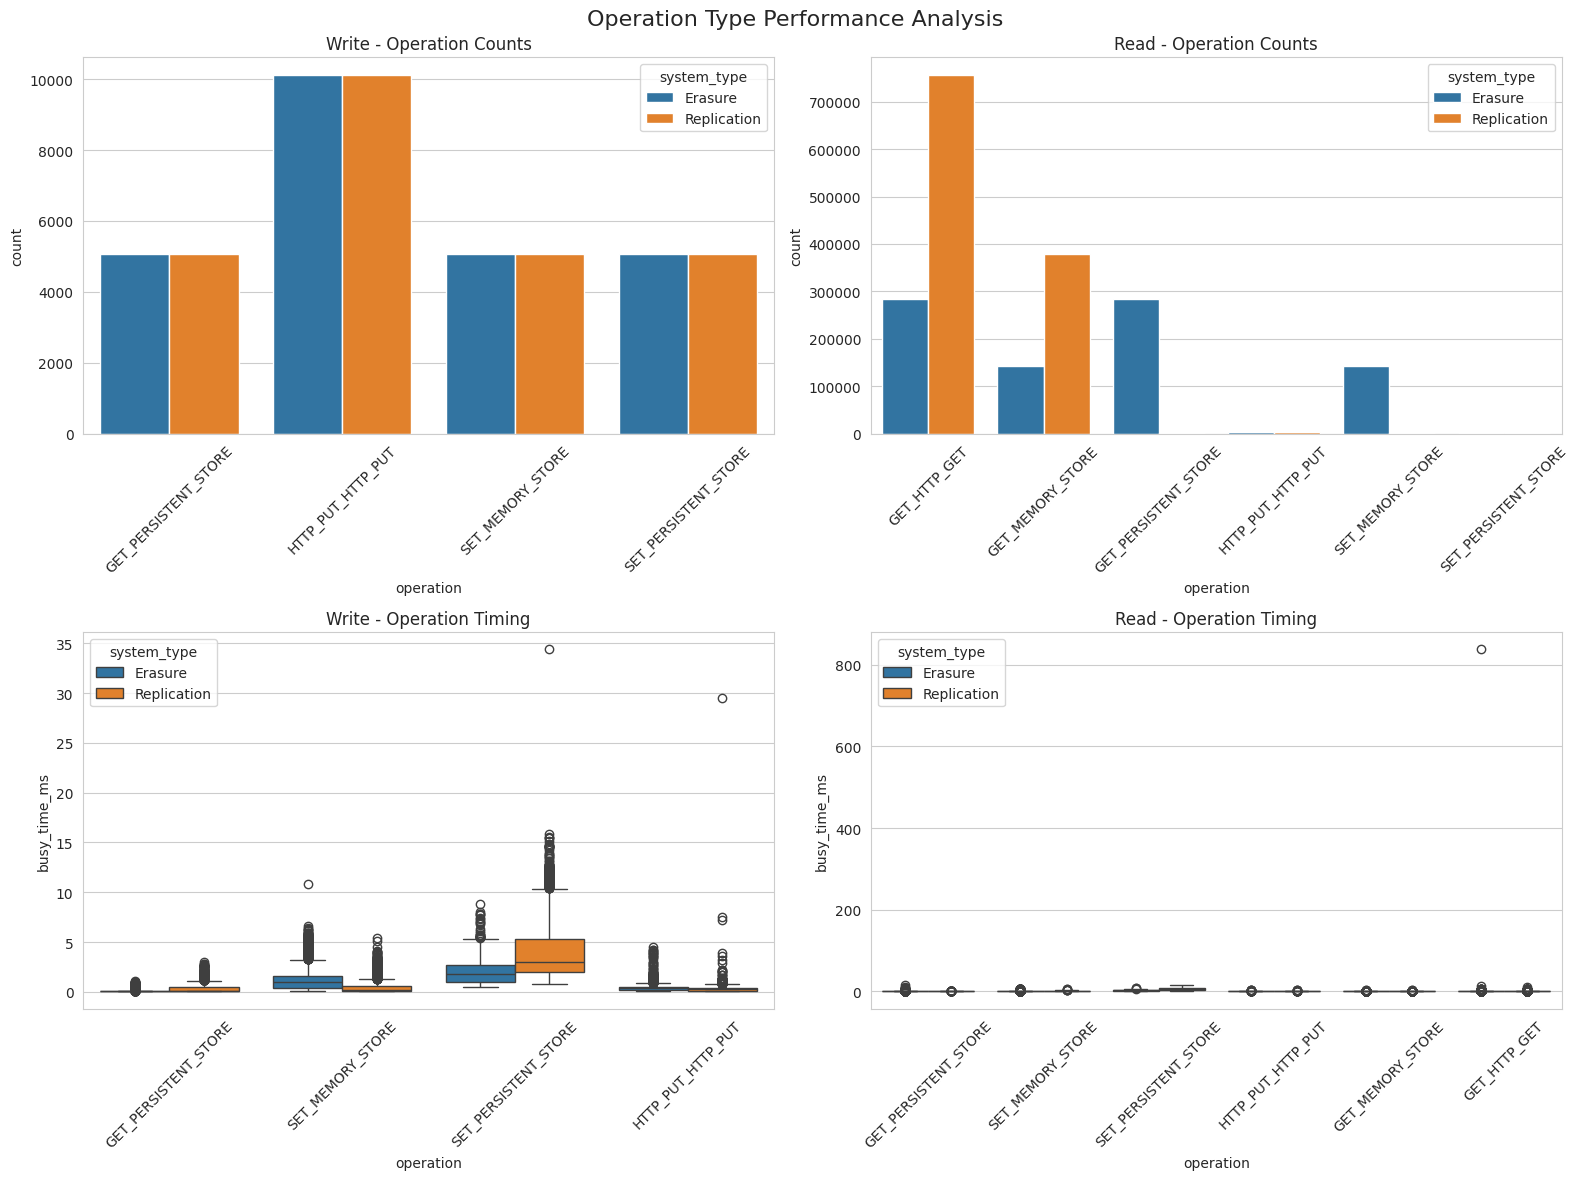

Bandwidth Impact Analysis:


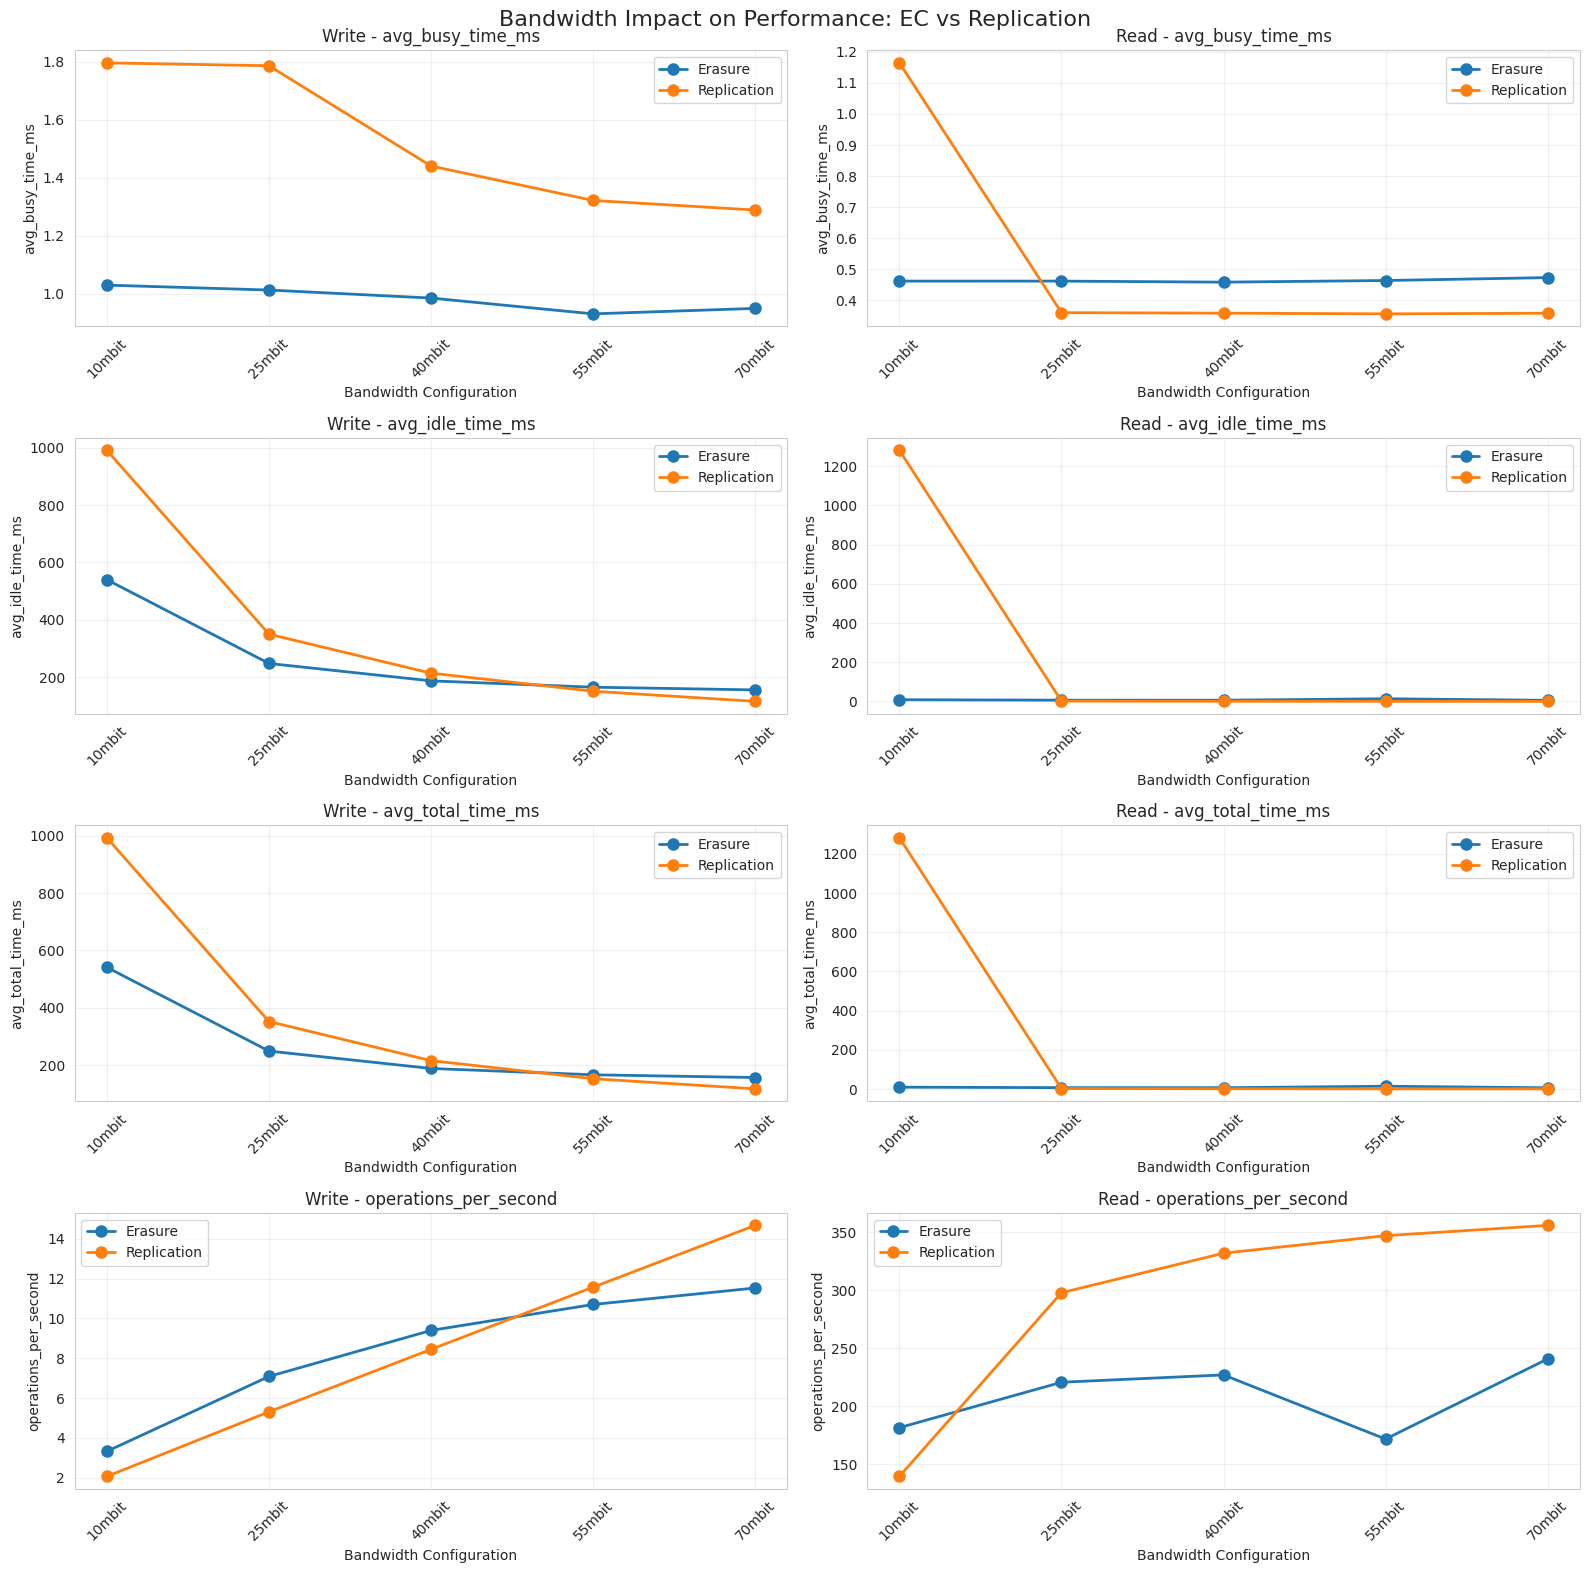

In [14]:
# Operation Type Analysis
def analyze_operation_types():
    """Analyze different operation types within the traces"""
    if not processed_data:
        print("No processed data available")
        return
    
    # Combine all timing data and analyze by operation type
    all_timings = pd.concat([pd_item['timings'] for pd_item in processed_data], ignore_index=True)
    
    if all_timings.empty:
        print("No timing data available")
        return
    
    # Group by operation type
    operation_stats = all_timings.groupby(['test_type', 'system_type', 'operation']).agg({
        'busy_time_ms': ['count', 'mean', 'std', 'median'],
        'total_time_ms': ['mean', 'std', 'median']
    }).round(3)
    
    print("Operation Type Analysis:")
    print("=" * 80)
    print(operation_stats)
    
    # Plot operation type comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Operation Type Performance Analysis', fontsize=16)
    
    # Count of operations by type
    op_counts = all_timings.groupby(['test_type', 'system_type', 'operation']).size().reset_index(name='count')
    
    for idx, test_type in enumerate(['write', 'read']):
        test_ops = op_counts[op_counts['test_type'] == test_type]
        
        if not test_ops.empty:
            ax = axes[0, idx]
            sns.barplot(data=test_ops, x='operation', y='count', hue='system_type', ax=ax)
            ax.set_title(f'{test_type.title()} - Operation Counts')
            ax.tick_params(axis='x', rotation=45)
    
    # Average timing by operation type
    for idx, test_type in enumerate(['write', 'read']):
        test_timings = all_timings[all_timings['test_type'] == test_type]
        
        if not test_timings.empty:
            ax = axes[1, idx]
            sns.boxplot(data=test_timings, x='operation', y='busy_time_ms', hue='system_type', ax=ax)
            ax.set_title(f'{test_type.title()} - Operation Timing')
            ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

analyze_operation_types()

# Bandwidth Impact Analysis
def analyze_bandwidth_impact():
    """Analyze the impact of bandwidth limitations on performance"""
    if summary_df.empty:
        print("No summary data available for bandwidth analysis")
        return
    
    # Check if we have multiple bandwidth configurations
    unique_bandwidths = summary_df['bandwidth'].unique()
    
    if len(unique_bandwidths) <= 1:
        print(f"Only one bandwidth configuration found: {unique_bandwidths}")
        return
    
    print("Bandwidth Impact Analysis:")
    print("=" * 50)
    
    metrics = ['avg_busy_time_ms', 'avg_idle_time_ms', 'avg_total_time_ms', 'operations_per_second']
    
    fig, axes = plt.subplots(len(metrics), 2, figsize=(16, 4 * len(metrics)))
    fig.suptitle('Bandwidth Impact on Performance: EC vs Replication', fontsize=16)
    
    for metric_idx, metric in enumerate(metrics):
        for test_idx, test_type in enumerate(['write', 'read']):
            ax = axes[metric_idx, test_idx] if len(metrics) > 1 else axes[test_idx]
            
            test_data = summary_df[summary_df['test_type'] == test_type]
            
            if not test_data.empty:
                # Create pivot table for line plot
                pivot_data = test_data.pivot_table(
                    index='bandwidth', 
                    columns='system_type', 
                    values=metric, 
                    aggfunc='mean'
                )
                
                for system in pivot_data.columns:
                    ax.plot(range(len(pivot_data.index)), pivot_data[system], 
                           marker='o', label=system, linewidth=2, markersize=8)
                
                ax.set_title(f'{test_type.title()} - {metric}')
                ax.set_xlabel('Bandwidth Configuration')
                ax.set_ylabel(metric)
                ax.set_xticks(range(len(pivot_data.index)))
                ax.set_xticklabels(pivot_data.index, rotation=45)
                ax.legend()
                ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

analyze_bandwidth_impact()